In [1]:
import os
import pandas as pd
from classes.DatasetLoader import DatasetLoader
from classes.Config import Config
from classes.train import UNetTrain
from classes.Model_evaluator import ModelEvaluator
from classes.Data_processor import DataProcessor
from classes.Img_resizer import ImageResizer
from classes.Result_util import ResultUtil
conf = Config()

In [2]:
dataProcessor = DataProcessor()

Current working directory: d:\VSCODE-library\deep-learning-QC\Segmentation
Number of train/val label files found: 583
Number of test set label files found: 568


In [3]:
### Processing raw data ###

#Converting labels to grayscale (black/white only)
dataProcessor.grayscale()

#Combining labels
dataProcessor.combine_seg_masks()

#Creating csv with processed data information
dataProcessor.create_processed_data_csv()

#Create flipped versions of the images and labels, tripling the dataset size
dataProcessor.create_augmentations()

Converted 583 train/val labels to grayscale
Converted 187 test labels by rater 'trym' to grayscale
Converted 186 test labels by rater 'brage' to grayscale
Converted 195 test labels by rater 'lars' to grayscale
Grouped 187 test files by rater 'trym' into 45 task groups
Grouped 186 test files by rater 'brage' into 45 task groups
Grouped 195 test files by rater 'lars' into 46 task groups
Grouped 583 train/val files into 134 task groups
Combined 134 train/val task groups into zone and spot masks
Combined 45 test task groups by rater 'trym' into zone and spot masks
Combined 45 test task groups by rater 'brage' into zone and spot masks
Combined 46 test task groups by rater 'lars' into zone and spot masks
Created processed_data.csv for training and validation set
Created test_processed_data.csv for test set


Creating augmentations: 100%|██████████| 268/268 [00:11<00:00, 23.45it/s]

Added 268 augmented images to processed_data.csv


In [8]:
### Resizing images and masks ###
resizer = ImageResizer(test_csv='test_processed_data_trym.csv')
resizer.resize()

100%|██████████| 402/402 [00:19<00:00, 21.11it/s]


Processed 402 training/validation images and masks
Resized to 512x256 (height x width)
Images saved to d:\VSCODE-library\deep-learning-QC\Segmentation\data\images
Masks saved to d:\VSCODE-library\deep-learning-QC\Segmentation\data\combined_labels


100%|██████████| 45/45 [00:02<00:00, 17.79it/s]

Processed 45 test images and masks
Resized to 512x256 (height x width)
Images saved to d:\VSCODE-library\deep-learning-QC\Segmentation\data\images
Masks saved to d:\VSCODE-library\deep-learning-QC\Segmentation\data\combined_labels


In [22]:
### Getting training, validation and test data sets ###

dir = os.path.join(conf.get_data_dir(), 'processed_data.csv')
test_dir = os.path.join(conf.get_data_dir(), 'test_raters_combined_masks.csv')
#test_dir = os.path.join(conf.get_data_dir(), 'test_processed_data_trym.csv')
dsl = DatasetLoader(pd.read_csv(dir), pd.read_csv(test_dir), batch_size=6, augmentation=True)
trainloader, valloader, testloader = dsl.load_data(num_workers=8, pin_memory=True)


Loading and verifying datasets...


Test data: 100%|██████████| 8/8 [00:07<00:00,  1.06batch/s]



=== Dataset Statistics ===
Training batches: 54
Validation batches: 14
Test batches: 8

Unique zone values (train): [0, 1, 2, 3]
Unique spot values (train): [0, 1, 2]
Unique zone values (val): [0, 1, 2, 3]
Unique spot values (val): [0, 1, 2]
Unique zone values (test): []
Unique spot values (test): []

Image dimensions: {(3, 512, 256)}
Zone mask dimensions: {(512, 256)}
Spot mask dimensions: {(512, 256)}

Checking for empty batches...


Checking Training batches: 100%|██████████| 54/54 [00:01<00:00, 43.68batch/s]


No empty batches found in Training dataset


Checking Validation batches: 100%|██████████| 14/14 [00:00<00:00, 49.04batch/s]


No empty batches found in Validation dataset


Checking Test batches: 100%|██████████| 8/8 [00:00<00:00, 48.51batch/s]


No empty batches found in Test dataset


In [15]:
### Training the model ###

model = UNetTrain(trainloader, valloader, 
        model_lr=5e-3, 
        model_weight_decay=0.0001, 
        model_betas=(0.9, 0.999), 
        scheduler_patience=3,
        scheduler_factor=0.3, 
        scheduler_min_lr=1e-6, 
        model_droput=0.2,
        max_grad_norm=3)
train_losses, val_losses = model.train(num_epochs=50, 
                                       patience=7, 
                                       min_delta=0.0005,
                                       window_size=5)

Validation: 100%|██████████| 14/14 [00:01<00:00, 10.90it/s, loss=1.7298]


Saved best model with validation loss: 1.3184
Epoch [1/50] - Train Loss: 1.8902 - Val Loss: 1.3184 - LR: 5.00e-03 - Best: 1.3184 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00, 10.27it/s, loss=1.5687]


Saved best model with validation loss: 1.0673
Epoch [2/50] - Train Loss: 0.8987 - Val Loss: 1.0673 - LR: 5.00e-03 - Best: 1.0673 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.93it/s, loss=1.6087]


Epoch [3/50] - Train Loss: 0.7436 - Val Loss: 1.6260 - LR: 5.00e-03 - Best: 1.0673 - No improve: 1/7


Validation: 100%|██████████| 14/14 [00:01<00:00, 10.02it/s, loss=1.4123]


Saved best model with validation loss: 1.0283
Epoch [4/50] - Train Loss: 0.5978 - Val Loss: 1.0283 - LR: 5.00e-03 - Best: 1.0283 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  9.43it/s, loss=0.2673]


Saved best model with validation loss: 0.5860
Epoch [5/50] - Train Loss: 0.4946 - Val Loss: 0.5860 - LR: 5.00e-03 - Best: 0.5860 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.55it/s, loss=0.1776]


Saved best model with validation loss: 0.2934
Epoch [6/50] - Train Loss: 0.4201 - Val Loss: 0.2934 - LR: 5.00e-03 - Best: 0.2934 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  9.06it/s, loss=0.1501]


Saved best model with validation loss: 0.2020
Epoch [7/50] - Train Loss: 0.4077 - Val Loss: 0.2020 - LR: 5.00e-03 - Best: 0.2020 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.42it/s, loss=0.1579]


Epoch [8/50] - Train Loss: 0.3991 - Val Loss: 0.2332 - LR: 5.00e-03 - Best: 0.2020 - No improve: 1/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  9.02it/s, loss=0.1973]


Epoch [9/50] - Train Loss: 0.3935 - Val Loss: 0.4993 - LR: 5.00e-03 - Best: 0.2020 - No improve: 2/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  9.20it/s, loss=0.1917]


Epoch [10/50] - Train Loss: 0.4031 - Val Loss: 0.2342 - LR: 5.00e-03 - Best: 0.2020 - No improve: 3/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  9.04it/s, loss=0.1399]


Saved best model with validation loss: 0.1779
Epoch [11/50] - Train Loss: 0.3459 - Val Loss: 0.1779 - LR: 5.00e-03 - Best: 0.1779 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.82it/s, loss=0.1209]


Saved best model with validation loss: 0.1663
Epoch [12/50] - Train Loss: 0.3122 - Val Loss: 0.1663 - LR: 5.00e-03 - Best: 0.1663 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.67it/s, loss=0.1228]


Epoch [13/50] - Train Loss: 0.3221 - Val Loss: 0.2310 - LR: 5.00e-03 - Best: 0.1663 - No improve: 1/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.55it/s, loss=0.1590]


Epoch [14/50] - Train Loss: 0.3080 - Val Loss: 0.2595 - LR: 5.00e-03 - Best: 0.1663 - No improve: 2/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.19it/s, loss=0.1260]


Epoch [15/50] - Train Loss: 0.2938 - Val Loss: 0.1685 - LR: 5.00e-03 - Best: 0.1663 - No improve: 3/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  9.11it/s, loss=0.1319]


Saved best model with validation loss: 0.1609
Epoch [16/50] - Train Loss: 0.2923 - Val Loss: 0.1609 - LR: 5.00e-03 - Best: 0.1609 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.18it/s, loss=0.1351]


Epoch [17/50] - Train Loss: 0.2887 - Val Loss: 0.1684 - LR: 5.00e-03 - Best: 0.1609 - No improve: 1/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.30it/s, loss=0.1042]


Epoch [18/50] - Train Loss: 0.2803 - Val Loss: 0.1940 - LR: 5.00e-03 - Best: 0.1609 - No improve: 2/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.61it/s, loss=0.1071]


Epoch [19/50] - Train Loss: 0.2750 - Val Loss: 0.1982 - LR: 5.00e-03 - Best: 0.1609 - No improve: 3/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.87it/s, loss=0.1491]



Learning rate changed from 5.00e-03 to 1.50e-03
Subtracting patience by 1 to give more time for convergence.
Epoch [20/50] - Train Loss: 0.2761 - Val Loss: 0.1862 - LR: 1.50e-03 - Best: 0.1609 - No improve: 3/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.19it/s, loss=0.1151]


Saved best model with validation loss: 0.1474
Epoch [21/50] - Train Loss: 0.2571 - Val Loss: 0.1474 - LR: 1.50e-03 - Best: 0.1474 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.80it/s, loss=0.1105]


Epoch [22/50] - Train Loss: 0.2453 - Val Loss: 0.1491 - LR: 1.50e-03 - Best: 0.1474 - No improve: 1/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.47it/s, loss=0.1178]


Epoch [23/50] - Train Loss: 0.2483 - Val Loss: 0.1604 - LR: 1.50e-03 - Best: 0.1474 - No improve: 2/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.73it/s, loss=0.1169]


Epoch [24/50] - Train Loss: 0.2488 - Val Loss: 0.1675 - LR: 1.50e-03 - Best: 0.1474 - No improve: 3/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.63it/s, loss=0.1614]



Learning rate changed from 1.50e-03 to 4.50e-04
Subtracting patience by 1 to give more time for convergence.
Epoch [25/50] - Train Loss: 0.2388 - Val Loss: 0.1694 - LR: 4.50e-04 - Best: 0.1474 - No improve: 3/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.81it/s, loss=0.1439]


Epoch [26/50] - Train Loss: 0.2307 - Val Loss: 0.1526 - LR: 4.50e-04 - Best: 0.1474 - No improve: 4/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.22it/s, loss=0.1330]


Saved best model with validation loss: 0.1440
Epoch [27/50] - Train Loss: 0.2273 - Val Loss: 0.1440 - LR: 4.50e-04 - Best: 0.1440 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s, loss=0.1477]


Epoch [28/50] - Train Loss: 0.2275 - Val Loss: 0.1574 - LR: 4.50e-04 - Best: 0.1440 - No improve: 1/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.82it/s, loss=0.1331]


Saved best model with validation loss: 0.1409
Epoch [29/50] - Train Loss: 0.2264 - Val Loss: 0.1409 - LR: 4.50e-04 - Best: 0.1409 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.68it/s, loss=0.1101]


Epoch [30/50] - Train Loss: 0.2284 - Val Loss: 0.1427 - LR: 4.50e-04 - Best: 0.1409 - No improve: 1/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  9.18it/s, loss=0.1264]


Epoch [31/50] - Train Loss: 0.2231 - Val Loss: 0.1425 - LR: 4.50e-04 - Best: 0.1409 - No improve: 2/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.83it/s, loss=0.1815]


Epoch [32/50] - Train Loss: 0.2262 - Val Loss: 0.1962 - LR: 4.50e-04 - Best: 0.1409 - No improve: 3/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.01it/s, loss=0.1569]



Learning rate changed from 4.50e-04 to 1.35e-04
Subtracting patience by 1 to give more time for convergence.
Epoch [33/50] - Train Loss: 0.2236 - Val Loss: 0.1508 - LR: 1.35e-04 - Best: 0.1409 - No improve: 3/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.25it/s, loss=0.1247]


Saved best model with validation loss: 0.1392
Epoch [34/50] - Train Loss: 0.2152 - Val Loss: 0.1392 - LR: 1.35e-04 - Best: 0.1392 - No improve: 0/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s, loss=0.1292]


Epoch [35/50] - Train Loss: 0.2184 - Val Loss: 0.1403 - LR: 1.35e-04 - Best: 0.1392 - No improve: 1/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.20it/s, loss=0.1322]


Epoch [36/50] - Train Loss: 0.2156 - Val Loss: 0.1413 - LR: 1.35e-04 - Best: 0.1392 - No improve: 2/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.26it/s, loss=0.1270]


Epoch [37/50] - Train Loss: 0.2163 - Val Loss: 0.1392 - LR: 1.35e-04 - Best: 0.1392 - No improve: 3/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.07it/s, loss=0.1319]



Learning rate changed from 1.35e-04 to 4.05e-05
Subtracting patience by 1 to give more time for convergence.
Epoch [38/50] - Train Loss: 0.2163 - Val Loss: 0.1407 - LR: 4.05e-05 - Best: 0.1392 - No improve: 3/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.55it/s, loss=0.1344]


Epoch [39/50] - Train Loss: 0.2134 - Val Loss: 0.1405 - LR: 4.05e-05 - Best: 0.1392 - No improve: 4/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.96it/s, loss=0.1318]


Epoch [40/50] - Train Loss: 0.2117 - Val Loss: 0.1400 - LR: 4.05e-05 - Best: 0.1392 - No improve: 5/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.43it/s, loss=0.1281]


Epoch [41/50] - Train Loss: 0.2142 - Val Loss: 0.1403 - LR: 4.05e-05 - Best: 0.1392 - No improve: 6/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.81it/s, loss=0.1400]



Learning rate changed from 4.05e-05 to 1.22e-05
Subtracting patience by 1 to give more time for convergence.
Epoch [42/50] - Train Loss: 0.2107 - Val Loss: 0.1421 - LR: 1.22e-05 - Best: 0.1392 - No improve: 6/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.38it/s, loss=0.1394]


Epoch [43/50] - Train Loss: 0.2141 - Val Loss: 0.1416 - LR: 1.22e-05 - Best: 0.1392 - No improve: 7/7


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.44it/s, loss=0.1413]

Epoch [44/50] - Train Loss: 0.2132 - Val Loss: 0.1422 - LR: 1.22e-05 - Best: 0.1392 - No improve: 8/7

Early stopping triggered after epoch 44
Best validation loss: 0.1392

Training completed!


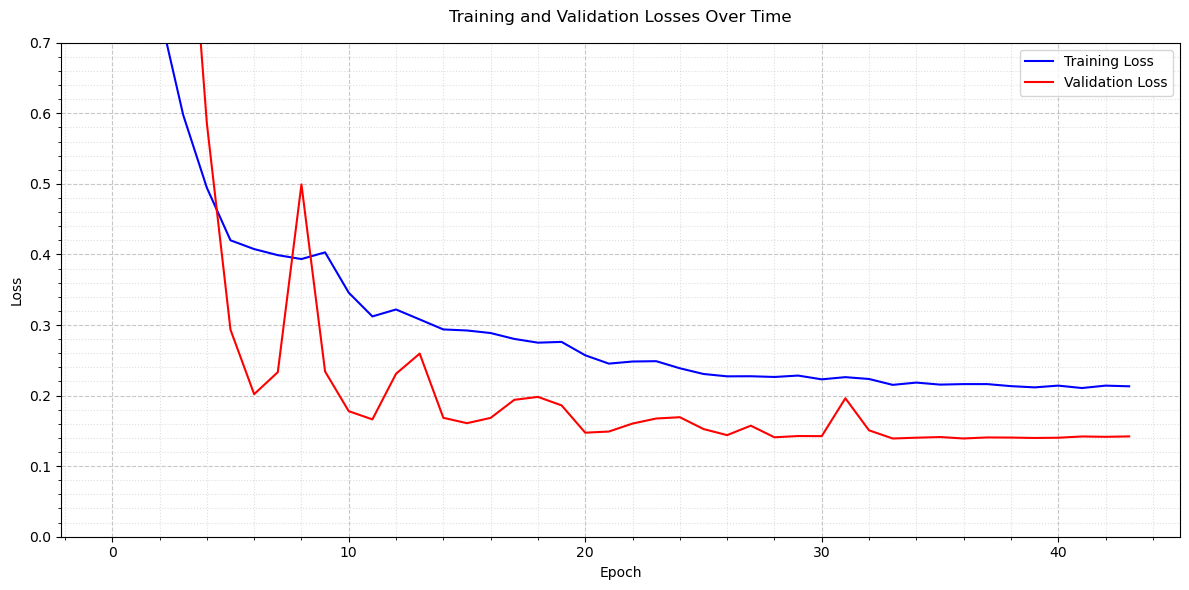

In [16]:
import matplotlib.pyplot as plt

# Create figure and axis with higher DPI for better quality
plt.figure(figsize=(12, 6), dpi=100)

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=1.5)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=1.5)

# Set y-axis limits to zoom in
plt.ylim(0, 0.7)  # Set max y value to 2.5

# Customize the plot
plt.title('Training and Validation Losses Over Time', pad=15)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')

# Add minor gridlines for better readability
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', alpha=0.4)

# Add margin to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
### Evaluating the model ###

evaluator = ModelEvaluator('saved_models/saved_segm_model.pth')
print('Validation set score:')
evaluator.calculate_dice_score(valloader)
print('Test set score:')
evaluator.calculate_dice_score(testloader)

Model checkpoint from epoch: 33
Validation set score:
Mean dice score zones: 0.928273693761007
Mean dice score spots: 0.740476271834554
Test set score:
Mean dice score zones: 0.897422902322473
Mean dice score spots: 0.6050090312086955


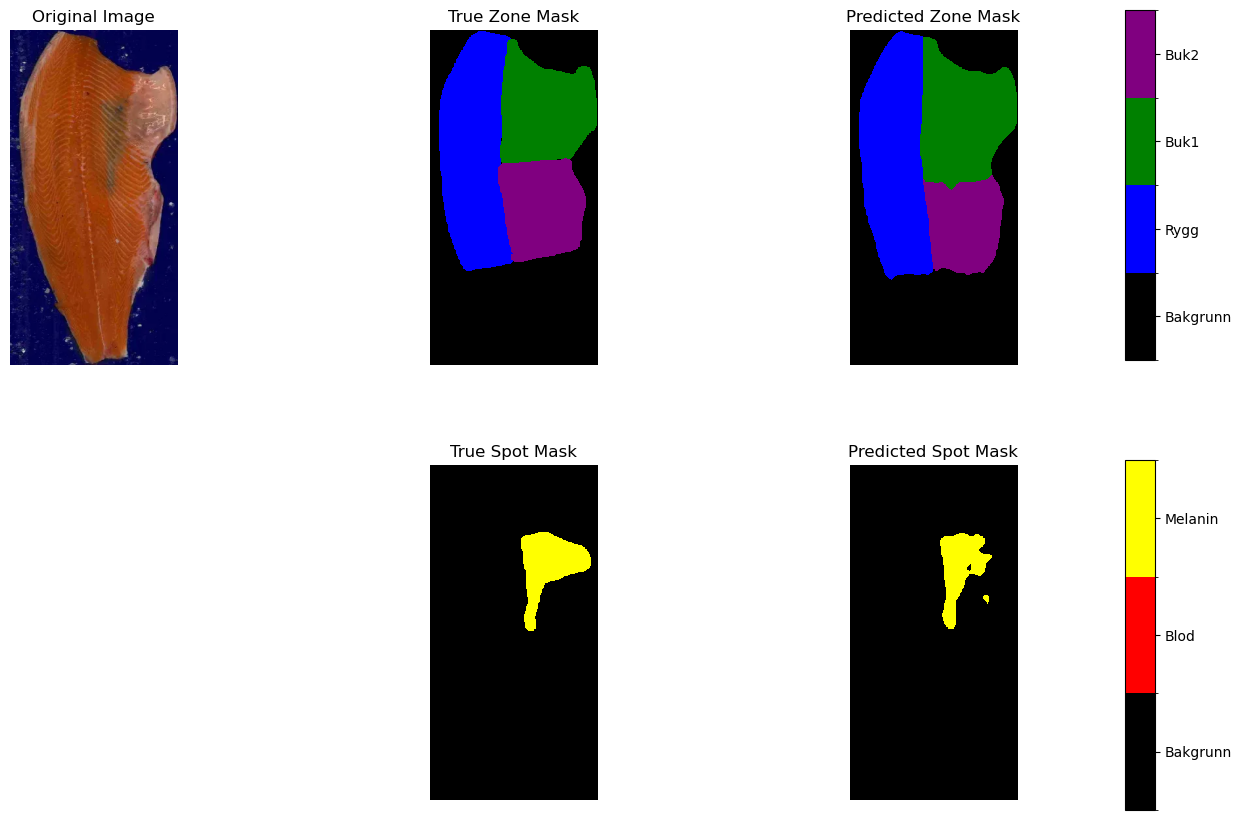

In [10]:
evaluator.view_single_result(testloader, 4, 1)

Image tensor type: <class 'numpy.ndarray'>, shape: (6, 3, 512, 256), dtype: float32
Unique values in zone masks: [0 1 2 3]
Unique values in spot masks: [0 1 2]
Input shape: (6, 3, 512, 256)
Preprocessed shape: (3, 512, 256)
Model checkpoint from epoch: 21
Unique values in spot_prediction in combineResults: [0 2]
Number of pixels classified as blood in spot_prediction mask: 0
Number of pixels classified as melanin in spot_prediction mask: 1326
Unique values in result: [0 1 2 3 5]
Result tensor type: <class 'numpy.ndarray'>, shape: (512, 256), dtype: int64


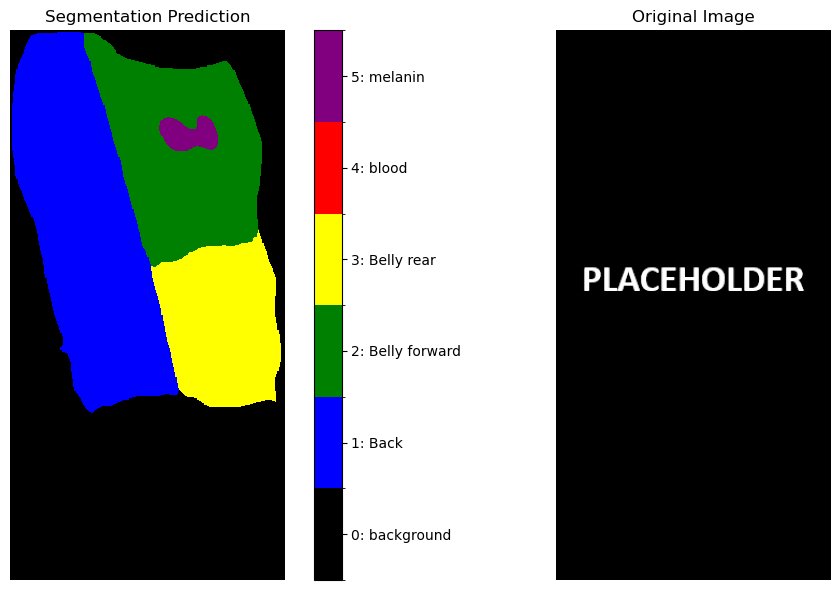

In [12]:
### Predicting and saving results ###

util = ResultUtil('saved_models/saved_segm_model.pth')
img, zone_true, spot_true = evaluator.viewLoaderItems(testloader, 5)
combined_pred = util.combineResults(img)
util.displayNumpy(combined_pred, 'data/placeholder.webp')

In [13]:
util.getPredictedZone(img)

Input shape: (6, 3, 512, 256)
Preprocessed shape: (3, 512, 256)
Model checkpoint from epoch: 21
Input shape: (3, 512, 256)
Preprocessed shape: (3, 512, 256)
Model checkpoint from epoch: 21
Unique values in spot_prediction in combineResults: [0 2]
Number of pixels classified as blood in spot_prediction mask: 0
Number of pixels classified as melanin in spot_prediction mask: 1326
Unique values in result: [0 1 2 3 5]
Result tensor type: <class 'numpy.ndarray'>, shape: (512, 256), dtype: int64
Overlap zones blood []
Overlap zones melanin ['Buk foran']
Class 0 count: 62352 pixels
Class 1 count: 31223 pixels
Class 2 count: 21406 pixels
Class 3 count: 14765 pixels
Class 4 count: 0 pixels
Class 5 count: 1326 pixels


({'zone': []}, {'zone': ['Buk foran']})

In [2]:
### Test agreement between test set labelers segmentation ###
from classes.SegmAgreeUtil import SegmentationDiceCalculator

agreeUtil = SegmentationDiceCalculator()
csv_paths = [
    'data/test_processed_data_trym.csv',  
    'data/test_processed_data_brage.csv',
    'data/test_processed_data_lars.csv', 
]
annotator_names = [
    'Trym',  
    'Brage',
    'Lars', 
]
agreeUtil.read_csv_files(csv_paths, annotator_names)

agreeUtil.match_images()
agreeUtil.process_all_masks()

agreeUtil.visualize_results('data/rater_comparison_results')

Loaded 45 entries for Trym
Loaded 45 entries for Brage
Loaded 46 entries for Lars
Found 45 images labeled by all annotators
Visualizing 5 worst and best zone mask comparisons...
  Worst zone #1: 33a515c9-d232-4ab6-9768-41a3c3aac4d0.webp, Score: 0.2933
  Best zone #1: 09fdef7b-e7e8-44b6-abc6-e30c6069b2c7.webp, Score: 0.9221
  Worst zone #2: 47af8349-c017-4a52-901a-195ad2a9aad3.webp, Score: 0.6840
  Best zone #2: 86a24d26-2ec5-4ba2-b314-364d29f73288.webp, Score: 0.9219
  Worst zone #3: d7f9bc9b-e253-48bd-9fd8-85fa692f2474.webp, Score: 0.8340
  Best zone #3: 068c7bc3-133c-4ba0-85ab-ee4afde15e26.webp, Score: 0.9120
  Worst zone #4: 57fa5df8-7584-4892-995d-70c5cf6f424b.webp, Score: 0.8421
  Best zone #4: 52e2b4d8-74be-40b6-bab8-4bb3f8c53552.webp, Score: 0.9119
  Worst zone #5: 47d77443-e150-455c-b75e-48320984307d.webp, Score: 0.8497
  Best zone #5: 61bacd5a-a070-40e7-86e0-68bfb0d2f8a1.webp, Score: 0.9110
Visualizing 5 worst and best spot mask comparisons...
  Worst spot #1: 20c14cc8-ece1-41

<>:3: SyntaxWarning: invalid escape sequence '\V'
<>:3: SyntaxWarning: invalid escape sequence '\V'
C:\Users\tbe00\AppData\Local\Temp\ipykernel_34468\2553859467.py:3: SyntaxWarning: invalid escape sequence '\V'
  pic = np.load('d:\VSCODE-library\deep-learning-QC\Segmentation\data\combined_labels/test/trym/spot/id-18-combined-spot.npy')


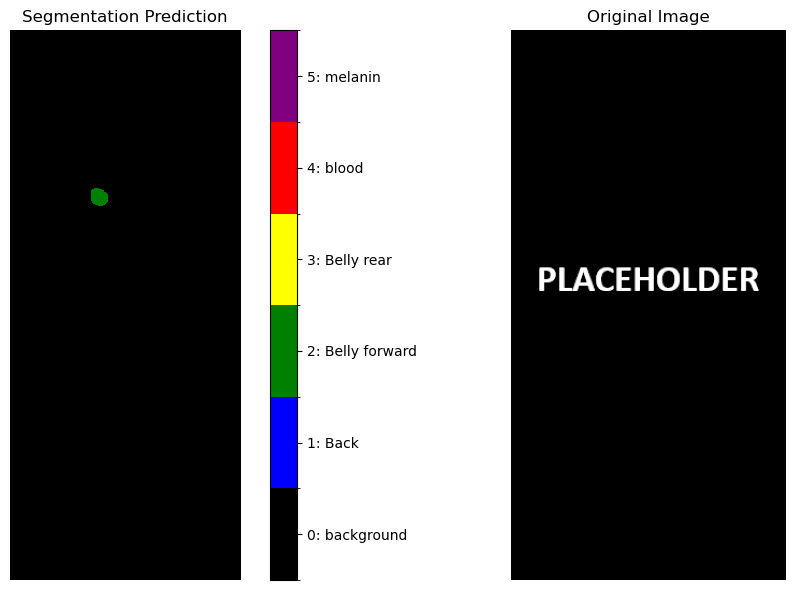

In [9]:
import numpy as np
util = ResultUtil('saved_models/saved_segm_model.pth')
pic = np.load('d:\VSCODE-library\deep-learning-QC\Segmentation\data\combined_labels/test/trym/spot/id-18-combined-spot.npy')
util.displayNumpy(pic, 'data/placeholder.webp')

In [5]:
import pandas as pd
import numpy as np
import os
# No longer need cv2 for saving, but keep it if you use it elsewhere.
# If you only use np.load and np.save, you could remove cv2 completely.
# import cv2

# --- User Configuration ---
# Replace with the actual paths to your three input CSV files
# Each CSV is now expected to have columns for image path, mask 1 path (.npy), and mask 2 path (.npy)
csv_file_1 = 'data/test_processed_data_brage.csv'
csv_file_2 = 'data/test_processed_data_lars.csv'
csv_file_3 = 'data/test_processed_data_trym.csv'

# Replace with the desired directory to save the combined masks (will be saved as .npy files)
# This can be a relative or absolute path; os.path.abspath will convert the final path to absolute
output_masks_dir = 'data/combined_labels/test/combined'

# Replace with the desired path and filename for the new output CSV file
output_csv_file = 'data/test_raters_combined_masks.csv'

# --- Script Logic ---

# Create the output directory for combined masks if it doesn't exist
os.makedirs(output_masks_dir, exist_ok=True)

# Read the three CSV files
try:
    # Assuming the first column is image path, second is mask 1 path, third is mask 2 path.
    # Adjust the column indices [0, 1, 2] if your CSV structure is different.
    df1 = pd.read_csv(csv_file_1, usecols=[7, 8, 9])
    df2 = pd.read_csv(csv_file_2, usecols=[7, 8, 9])
    df3 = pd.read_csv(csv_file_3, usecols=[7, 8, 9])
except FileNotFoundError as e:
    print(f"Error: Input CSV file not found. {e}")
    exit()
except Exception as e:
    print(f"Error reading CSV files: {e}")
    exit()

# Rename columns for clarity before merging
# Ensure these names match the order they appear in your usecols list above
df1.columns = ['image_path', 'mask1_path_1', 'mask2_path_1']
df2.columns = ['image_path', 'mask1_path_2', 'mask2_path_2']
df3.columns = ['image_path', 'mask1_path_3', 'mask2_path_3']

# Merge the dataframes on the image path
merged_df = pd.merge(df1, df2, on='image_path', how='inner')
merged_df = pd.merge(merged_df, df3, on='image_path', how='inner')

# List to store data for the new CSV file
new_csv_data = []

# Iterate through the merged dataframe
for index, row in merged_df.iterrows():
    image_path = row['image_path']
    mask1_path_1 = row['mask1_path_1']
    mask1_path_2 = row['mask1_path_2']
    mask1_path_3 = row['mask1_path_3']
    mask2_path_1 = row['mask2_path_1']
    mask2_path_2 = row['mask2_path_2']
    mask2_path_3 = row['mask2_path_3']

    # Assume success initially
    combined_mask1_path_abs = 'Error processing mask 1' # Initialize with error state
    combined_mask2_path_abs = 'Error processing mask 2' # Initialize with error state
    processing_error = None

    try:
        # --- Process Mask Set 1 ---
        # Load masks using numpy.load()
        try:
            mask1_1 = np.load(mask1_path_1)
            mask1_2 = np.load(mask1_path_2)
            mask1_3 = np.load(mask1_path_3)
        except FileNotFoundError:
             raise FileNotFoundError(f"Mask 1 file not found for image {image_path}")
        except Exception as e:
             raise Exception(f"Error loading Mask 1 .npy files: {e}")


        # Ensure masks have the same dimensions
        if not (mask1_1.shape == mask1_2.shape == mask1_3.shape):
             raise ValueError(f"Mask 1s for image {image_path} have different dimensions ({mask1_1.shape}, {mask1_2.shape}, {mask1_3.shape}).")

        # Combine Mask 1s (assuming masks are binary or grayscale where higher value means 'on')
        combined_mask1 = np.maximum.reduce([mask1_1, mask1_2, mask1_3])

        # Determine the filename for the combined mask 1
        image_filename = os.path.basename(image_path)
        name, ext = os.path.splitext(image_filename)
        # Save as a .npy file
        combined_mask1_filename = f"{name}_combined_mask1.npy"
        combined_mask1_path_relative = os.path.join(output_masks_dir, combined_mask1_filename)

        # Get the absolute path
        combined_mask1_path_abs = os.path.abspath(combined_mask1_path_relative)

        # Save the combined mask using np.save
        np.save(combined_mask1_path_abs, combined_mask1)


        # --- Process Mask Set 2 ---
        # Load masks using numpy.load()
        try:
            mask2_1 = np.load(mask2_path_1)
            mask2_2 = np.load(mask2_path_2)
            mask2_3 = np.load(mask2_path_3)
        except FileNotFoundError:
            raise FileNotFoundError(f"Mask 2 file not found for image {image_path}")
        except Exception as e:
            raise Exception(f"Error loading Mask 2 .npy files: {e}")


        # Ensure masks have the same dimensions
        if not (mask2_1.shape == mask2_2.shape == mask2_3.shape):
             raise ValueError(f"Mask 2s for image {image_path} have different dimensions ({mask2_1.shape}, {mask2_2.shape}, {mask2_3.shape}).")

        # Combine Mask 2s
        combined_mask2 = np.maximum.reduce([mask2_1, mask2_2, mask2_3])

        # Determine the filename for the combined mask 2
        combined_mask2_filename = f"{name}_combined_mask2.npy" # Using name from Mask 1 processing
        combined_mask2_path_relative = os.path.join(output_masks_dir, combined_mask2_filename)

        # Get the absolute path
        combined_mask2_path_abs = os.path.abspath(combined_mask2_path_relative)

        # Save the combined mask using np.save
        np.save(combined_mask2_path_abs, combined_mask2)

        # If both sets processed successfully, append the absolute paths
        new_csv_data.append({
            'image_path': image_path,
            'combined_mask1_path': combined_mask1_path_abs,
            'combined_mask2_path': combined_mask2_path_abs
        })

    except FileNotFoundError as e:
        print(f"Warning: {e}. Skipping combination for this image.")
        # Append error indicators if files not found
        new_csv_data.append({
            'image_path': image_path,
            'combined_mask1_path': f'File Not Found Error: {e}',
            'combined_mask2_path': f'File Not Found Error: {e}'
        })
        continue # Move to the next image

    except ValueError as e:
         print(f"Warning: Dimension mismatch for image {image_path}: {e}. Skipping combination.")
         # Append error indicators for dimension mismatch
         new_csv_data.append({
            'image_path': image_path,
            'combined_mask1_path': f'Dimension Error: {e}',
            'combined_mask2_path': f'Dimension Error: {e}'
        })
         continue # Move to the next image

    except Exception as e:
        print(f"Error processing image {image_path}: {e}. Skipping combination.")
        # Append generic error indicators
        new_csv_data.append({
            'image_path': image_path,
            'combined_mask1_path': f'Processing Error: {e}',
            'combined_mask2_path': f'Processing Error: {e}'
        })
        continue # Move to the next image


# Create a new dataframe from the collected data
new_df = pd.DataFrame(new_csv_data)

# --- Rename the mask columns in the output DataFrame ---
new_df = new_df.rename(columns={
    'combined_mask1_path': 'zone_label_path',
    'combined_mask2_path': 'spot_label_path'
})
# -------------------------------------------------------


# Save the new dataframe to a CSV file
if not new_df.empty:
    try:
        new_df.to_csv(output_csv_file, index=False)
        print(f"Successfully created new CSV file at: {output_csv_file}")
        print(f"Combined masks saved to: {output_masks_dir} (in .npy format)")
    except Exception as e:
        print(f"Error saving the new CSV file: {e}")
else:
    print("No combined masks data was generated. The output CSV file will not be created.")

print("Script finished.")

Successfully created new CSV file at: data/test_raters_combined_masks.csv
Combined masks saved to: data/combined_labels/test/combined (in .npy format)
Script finished.


<>:1: SyntaxWarning: invalid escape sequence '\9'
<>:1: SyntaxWarning: invalid escape sequence '\9'
C:\Users\tbe00\AppData\Local\Temp\ipykernel_15212\1160623576.py:1: SyntaxWarning: invalid escape sequence '\9'
  view = np.load('data/combined_labels/test/combined\9df4565f-bfee-4dba-972d-8e69225c02d8_combined_mask2.npy')


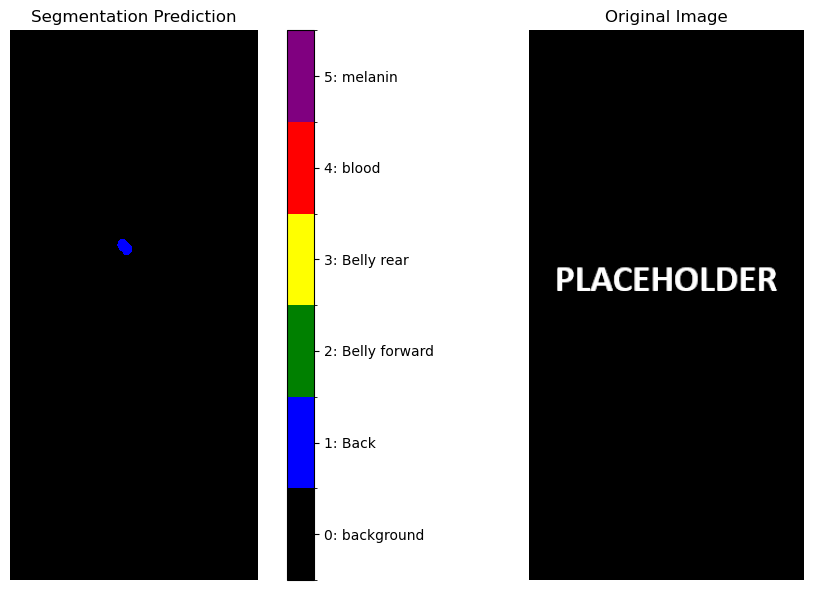

In [11]:
view = np.load('data/combined_labels/test/combined\9df4565f-bfee-4dba-972d-8e69225c02d8_combined_mask2.npy')
util = ResultUtil('saved_models/saved_segm_model.pth')
util.displayNumpy(view, 'data/placeholder.webp')